In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")


Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [6]:
path = "/kaggle/input/coco2017"
x = load(os.path.join(path, 'train2017/train2017/000000000025.jpg'))
print(x.shape)

(426, 640, 3)


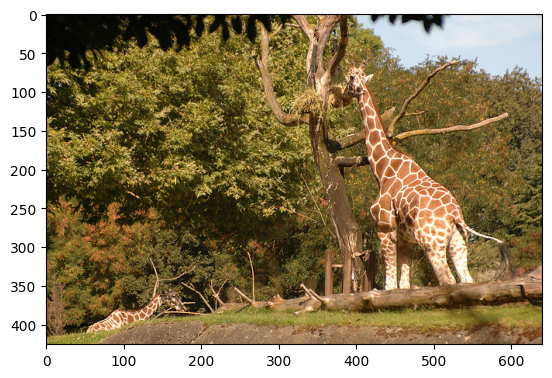

In [7]:
plt.imshow(x/255.0)

In [8]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [9]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

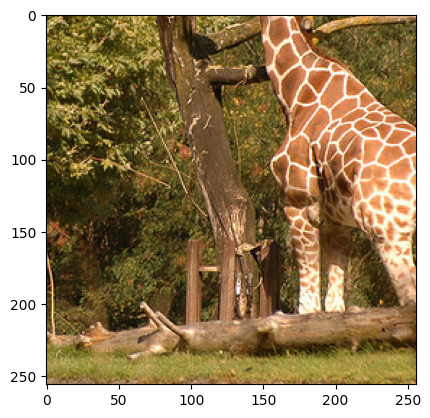

In [10]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [11]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image
def resize_300(real_image):
    real_image = tf.image.resize(real_image, [300, 300], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [12]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [13]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

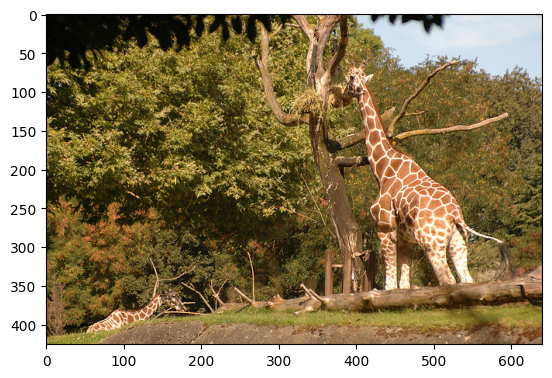

In [14]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [15]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = resize_300(real_image)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [16]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [18]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "/train2017/train2017/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [19]:
test_dataset = tf.data.Dataset.list_files(path + '/val2017/val2017/*.jpg')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [20]:
# # Load pre-trained VGG model
# vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the VGG model layers
# vgg_model.trainable = False

# # Define function to preprocess images
# def preprocess_image(image):
#     image = tf.image.resize(image, (224, 224))
#     image = tf.keras.applications.vgg16.preprocess_input(image)
#     return image

# # Define function to compute LPIPS score
# def compute_lpips_score(image1, image2):
#     image1_features = vgg_model(preprocess_image(image1))
#     image2_features = vgg_model(preprocess_image(image2))
#     lpips_distance = tf.norm(image1_features - image2_features, ord='euclidean', axis=1)
#     return lpips_distance.numpy()

In [21]:
# downsample block
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 213, 320, 3)


In [22]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.3))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 426, 640, 3)


In [23]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(8, 4, batchnorm=False),
        downsample(16, 4),
        downsample(32, 4),
        downsample(64, 4, dropout = True),
        downsample(128, 4, dropout = True),
        downsample(256, 4, dropout = True),
        downsample(256, 4, dropout = True)
    ]

    up_stack = [
        upsample(256, 4, dropout = True),
        upsample(128, 4, dropout=True),
        upsample(64, 4, dropout=True),
        upsample(32, 4, dropout=True),
        upsample(16, 4),
        upsample(8, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

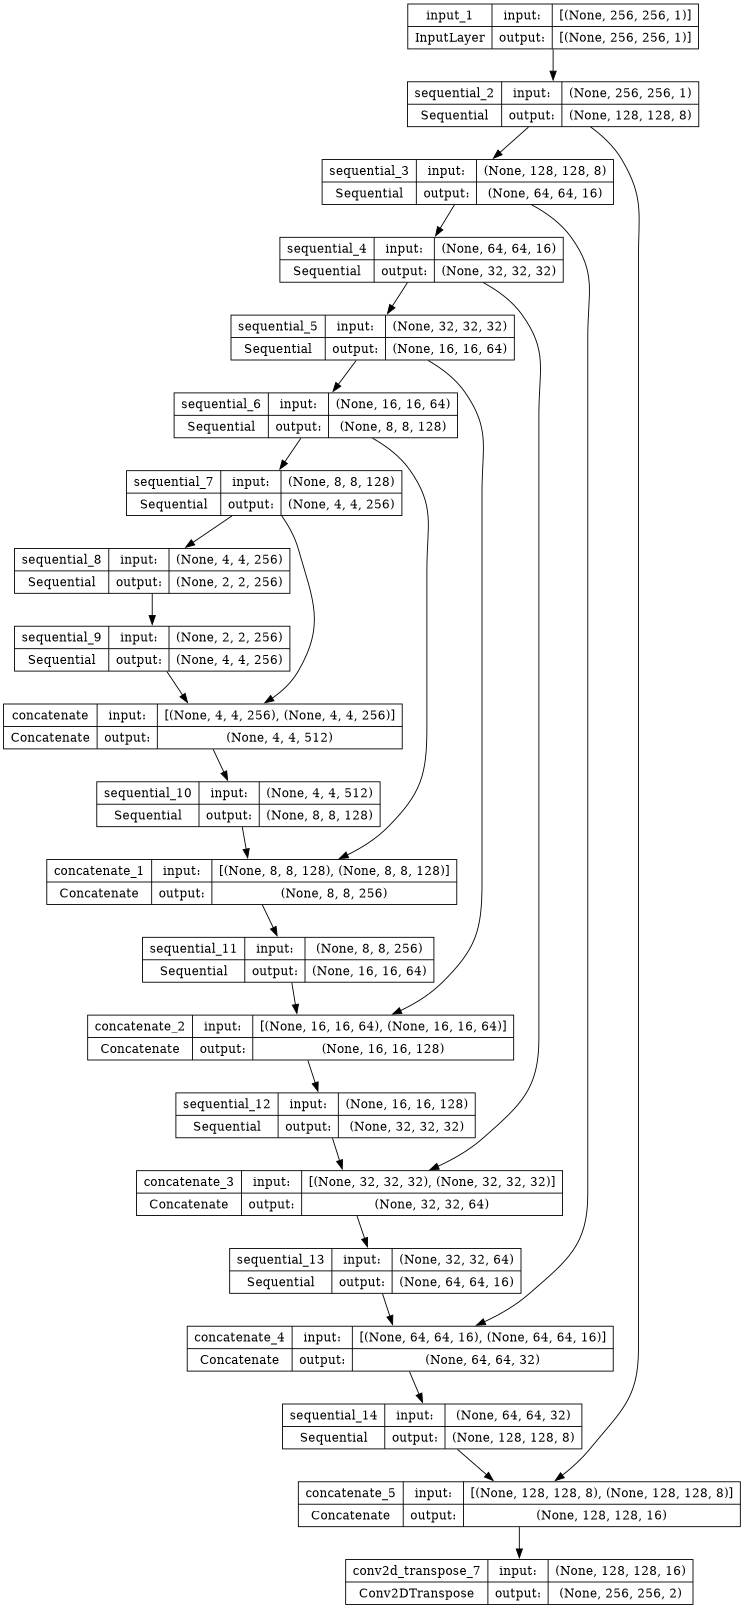

In [24]:
gen = generator()
plot_model(gen, show_shapes=True, dpi = 64)

In [25]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    down1 = downsample(64,4,False)(tar)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = tar, outputs = last)

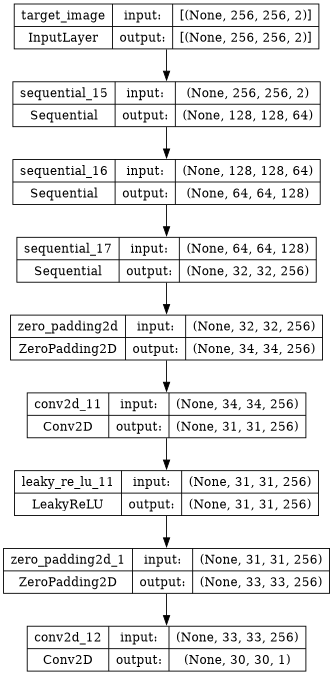

In [26]:
disc = discriminator()
plot_model(disc, show_shapes=True, dpi = 64)

In [27]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [28]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError, MeanSquaredError

# Define generator and discriminator architectures
# Define generator and discriminator models

# Load pre-trained VGG19 model for perceptual loss
# vgg_model = VGG19(weights='imagenet', include_top=False)

# Define loss functions
bce_loss = BinaryCrossentropy(from_logits=True)
mae_loss = MeanAbsoluteError()
mse_loss = MeanSquaredError()

In [29]:
lambda_adv = 1
lambda_l1 = 80
lambda_l2 = 15
lambda_perceptual = 0.2

In [30]:
# def perceptual_loss(y_true, y_pred):
#     y_true = tf.keras.applications.vgg19.preprocess_input(y_true)
#     y_pred = tf.keras.applications.vgg19.preprocess_input(y_pred)
#     features_true = vgg_model(y_true)
#     features_pred = vgg_model(y_pred)
#     return mae_loss(features_true, features_pred)


In [31]:
def generator_loss(disc_generated_output, input_image, generated_images, real_images):
    adv_loss = bce_loss(tf.ones_like(disc_generated_output), disc_generated_output)

    # Compute L1 loss
    l1_loss = mae_loss(real_images, generated_images)

    # Compute L2 loss
#     l2_loss = mse_loss(real_images, generated_images)

    # Compute perceptual loss
#     perceptual_loss_val = perceptual_loss(create_rgb_image(input_image, real_images), create_rgb_image(input_image,generated_images))

    # Total generator loss
    gen_loss =  lambda_adv * adv_loss + lambda_l1 * l1_loss 
    return gen_loss, adv_loss, l1_loss, 0,0 

In [32]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [34]:
generator_optimizer = Adam(lr= 2e-5, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-5, beta_1=0.5)

In [35]:
epochs = 150

In [36]:
!pip install lpips
import lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.6 MB/s eta 0:00:00


In [37]:
# Create a loss function using the alexnet model
lpips_loss_fn = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 42.3MB/s]


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [38]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the VGG19 model
vgg = VGG19(weights='imagenet', include_top=False)

# Select the layers you want to use for the LPIPS score
selected_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

# Create a model that outputs the selected layers
outputs = [vgg.get_layer(name).output for name in selected_layers]
model = Model(inputs=vgg.input, outputs=outputs)

# Make sure the VGG model is not trainable
model.trainable = False

def lpips_score(image1, image2):
    # Get the features for both images
    image1_features = model(image1)
    image2_features = model(image2)

    # Initialize the score
    score = 0

    # For each feature layer...
    for f1, f2 in zip(image1_features, image2_features):
        # ... compute the mean squared error between the features
        mse = tf.reduce_mean((f1 - f2)**2)
        # ... and add it to the score
        score += mse

    return score

80134624/80134624 [==============================] - 4s 0us/step


In [39]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc( target, training=True)
        disc_generated_output = disc(gen_output, training=True)
        gen_total_loss, gen_adv_loss, gen_l1_loss, gen_l2_loss, gen_perceptual_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

        ssim_values = tf.image.ssim(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
        psnr_values = tf.image.psnr(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
        lpips_values = lpips_score(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output))
#         if epoch > 10:
        if training_discriminator:
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
#         else:
#             generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
#             discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
#             generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
#             discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_adv_loss, gen_l1_loss, gen_l2_loss, gen_perceptual_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [40]:
@tf.function
def test_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc( target)
    disc_generated_output = disc(gen_output)

    gen_total_loss, gen_adv_loss, gen_l1_loss, gen_l2_loss, gen_perceptual_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

    ssim_values = tf.image.ssim(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
    psnr_values = tf.image.psnr(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
    lpips_values = lpips_score(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output))
    
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_adv_loss, gen_l1_loss, gen_l2_loss, gen_perceptual_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [41]:
os.mkdir('/kaggle/working/gen_output/')

In [42]:
def display_one_random_test_image(input_, target, gen_model, epoch):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
    lpips = lpips_score(tf.reshape(create_rgb_image(input_, target), (1, 256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1, 256,256,3)))

    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title(f'Generated Output -- epoch {epoch}')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.savefig(f'/kaggle/working/gen_output/epoch_{epoch}.png')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))
    print('LPIPS Score: {}'.format(lpips))

In [43]:
def display_random_test_image(test_ds, gen_model, epoch):
    # Shuffle the dataset and take one batch
    random_test_batch = test_ds.shuffle(buffer_size=len(test_ds)).take(1)

    # Extract input and target from the batch
    random_test_input, random_test_target = list(random_test_batch)[0]

    # Display the image
    display_one_random_test_image(tf.reshape(random_test_input[0], (1,256,256,1)),tf.reshape(random_test_target[0],(1,256,256,2)), gen_model, epoch)
display_random_test_image

<function __main__.display_random_test_image(test_ds, gen_model, epoch)>

Displaying one random test image...


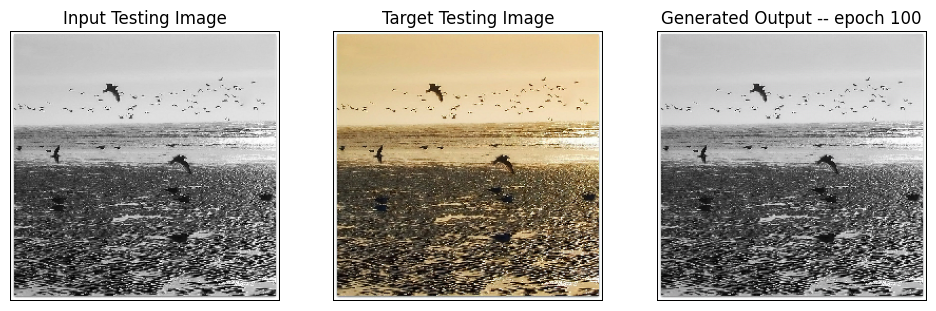

SSIM Score: 0.9673860669136047
PSNR Score: 20.204877853393555
LPIPS Score: 0.6325849294662476


In [44]:
display_random_test_image(test_dataset , gen,100)

In [45]:
import random
from tqdm import tqdm

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_generator_l2_losses = []
each_epoch_train_generator_perceptual_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_train_lpips = []
each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_generator_l2_losses = []
train_generator_perceptual_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_generator_l2_losses = []
test_generator_perceptual_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
training_lpips = []
testing_ssim = []
testing_psnr = []
testing_lpips = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):
    time_start = time.time()
    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_generator_l2_losses, each_epoch_train_generator_perceptual_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_generator_l2_losses, each_epoch_test_generator_perceptual_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_generator_l2_losses, train_generator_perceptual_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_l2_losses, test_generator_gan_losses, test_generator_l1_losses, test_generator_perceptual_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records, LAMBDA, each_epoch_train_lpips, each_epoch_test_lpips, training_lpips, testing_lpips


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate

    for epoch in range(epochs):
        start = time.time()
        train_count = 0
        test_count = 0
        
        # Initialize tqdm to track progress
#         progress_bar_train = tqdm(total=len(train_ds), desc=f'Epoch {epoch + 1}/{epochs}', unit='batches')
#         progress_bar_test = tqdm(total=len(test_ds), desc=f'Epoch {epoch + 1}/{epochs}', unit='batches')

        
        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            train_gen_loss, train_gen_gan_loss, train_gen_l1_loss,train_gen_l2_loss, train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
            each_epoch_train_generator_l2_losses.append(train_gen_l2_loss)
            each_epoch_train_generator_perceptual_losses.append(train_gen_perceptual_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            each_epoch_train_lpips.append(tf.reduce_mean(train_lpips.numpy()))
            train_count += 1
            
#             progress_bar_train.update(1)

        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.2f} gan_loss:{:.2f} l1_loss:{:.2f} l2_loss:{:.2f} perceptual_loss:{:.2f} Discriminator-- total_loss:{:.2f} real_loss:{:.2f} generated_loss:{:.2f} --- SSIM {:.2f} PSNR {:.2f} LPIPS {:.2f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_l2_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_train_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print(f"Number of iteration {train_count}")
#         progress_bar_train.close()
        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
        train_generator_l2_losses.append(np.mean(each_epoch_train_generator_l2_losses))
        train_generator_perceptual_losses.append(np.mean(each_epoch_train_generator_perceptual_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))
        training_lpips.append(np.mean(each_epoch_train_lpips))
        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss,test_gen_l2_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips = test_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
            each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
            each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
            each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
#             progress_bar_test.update(1)

        print("Testing Details")
        print("Generator-- total_loss:{:.2f} gan_loss:{:.2f} l1_loss:{:.2f} l2_loss:{:.2f} perceptual_loss:{:.2f} Discriminator-- total_loss:{:.2f} real_loss:{:.2f} generated_loss:{:.2f} --- SSIM {:.2f} PSNR {:.2f} LPIPS {:.2f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_l2_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print(f"Number of iteration {test_count}")
#         progress_bar_test.close()
#         LAMBDA = LAMBDA * 1.006
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
        test_generator_l2_losses.append(np.mean(each_epoch_test_generator_l2_losses))
        test_generator_perceptual_losses.append(np.mean(each_epoch_test_generator_perceptual_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        testing_lpips.append(np.mean(each_epoch_test_lpips))
        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_l2_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr),np.mean(each_epoch_train_lpips), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_l2_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
        each_epoch_test_generator_l2_losses = []
        each_epoch_test_generator_perceptual_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_test_lpips = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
        each_epoch_train_generator_l2_losses = []
        each_epoch_train_generator_perceptual_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        each_epoch_train_lpips = []
        if epoch == 0 or epoch % 3 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(test_ds, gen_model, epoch+1)
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if epoch > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        


#         LAMBDA = LAMBDA*1.003
            # If the condition is met for 3 consecutive epochs, reduce the learning rate
        if time.time() - time_start > 41000:
            stop_training = True
        if consecutive_epochs_high_loss == 3:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.5, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0

        # Check the flag variable
        if stop_training:
            break

In [46]:
tf.config.run_functions_eagerly(True)

Epoch 0
Training Details
Generator-- total_loss:19.18 gan_loss:12.61 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.20 real_loss:0.10 generated_loss:0.10 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 1 is 2050.995972633362 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:5.41 gan_loss:0.00 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:22.91 real_loss:22.90 generated_loss:0.01 --- SSIM 0.62 PSNR 18.93 LPIPS 1.64
Time taken for epoch 1 is 2109.895341157913 sec
Number of iteration 313
Displaying one random test image...


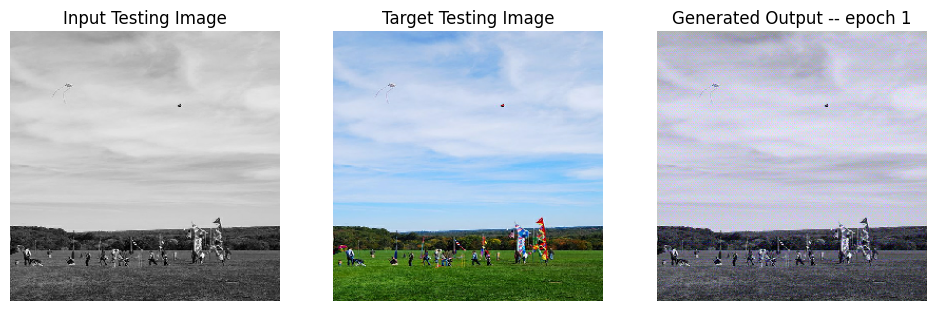

SSIM Score: 0.36905643343925476
PSNR Score: 18.42826271057129
LPIPS Score: 1.8569355010986328
Epoch 1
Training Details
Generator-- total_loss:21.09 gan_loss:14.52 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 2 is 2032.4006838798523 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:5.40 gan_loss:0.00 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:32.63 real_loss:32.63 generated_loss:0.00 --- SSIM 0.62 PSNR 18.94 LPIPS 1.64
Time taken for epoch 2 is 2091.3168194293976 sec
Number of iteration 313
Epoch 2
Training Details
Generator-- total_loss:63.35 gan_loss:56.78 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.31 real_loss:0.11 generated_loss:0.20 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 3 is 2106.0504233837128 sec
Number of iteration 7393
Testing Details
Generator-- total_los

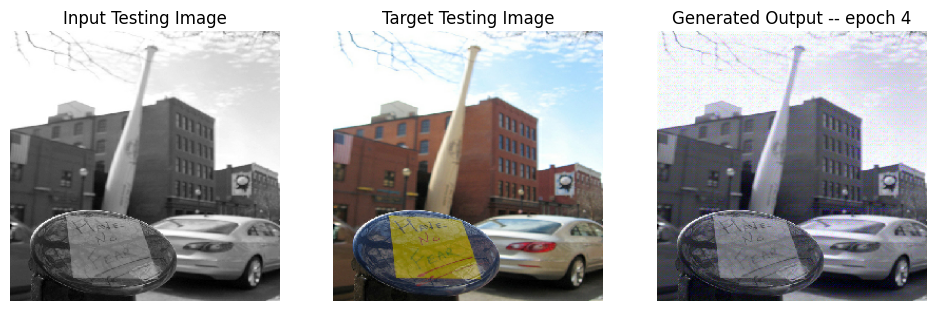

SSIM Score: 0.4896620213985443
PSNR Score: 18.632272720336914
LPIPS Score: 1.9488980770111084
Epoch 4
Training Details
Generator-- total_loss:174.72 gan_loss:168.15 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 5 is 2050.1351883411407 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:6.46 gan_loss:1.06 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:264.53 real_loss:172.66 generated_loss:91.87 --- SSIM 0.62 PSNR 18.95 LPIPS 1.63
Time taken for epoch 5 is 2108.1636641025543 sec
Number of iteration 313
Epoch 5
Training Details
Generator-- total_loss:178.78 gan_loss:172.21 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.09 real_loss:0.07 generated_loss:0.03 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 6 is 2070.250094652176 sec
Number of iteration 7393
Testing Details
Generator-- tot

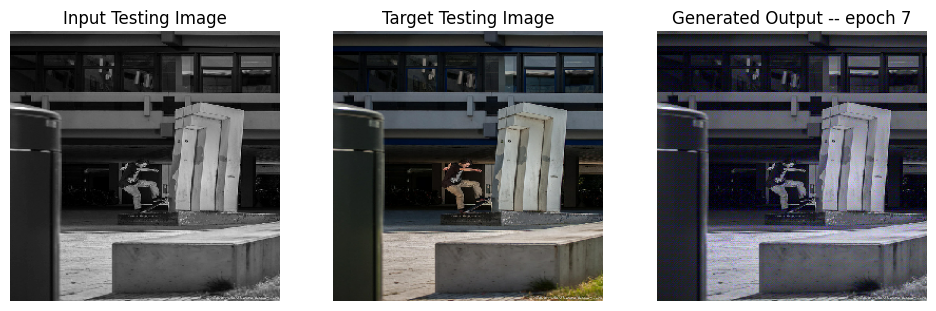

SSIM Score: 0.636497974395752
PSNR Score: 23.143972396850586
LPIPS Score: 0.7596367597579956
Epoch 7
Training Details
Generator-- total_loss:273.66 gan_loss:267.09 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 8 is 2071.6583490371704 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:22.11 gan_loss:16.71 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:75.29 real_loss:64.27 generated_loss:11.02 --- SSIM 0.62 PSNR 18.95 LPIPS 1.63
Time taken for epoch 8 is 2130.930286884308 sec
Number of iteration 313
Epoch 8
Training Details
Generator-- total_loss:253.66 gan_loss:247.09 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.07 real_loss:0.03 generated_loss:0.04 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 9 is 2089.901521205902 sec
Number of iteration 7393
Testing Details
Generator-- total

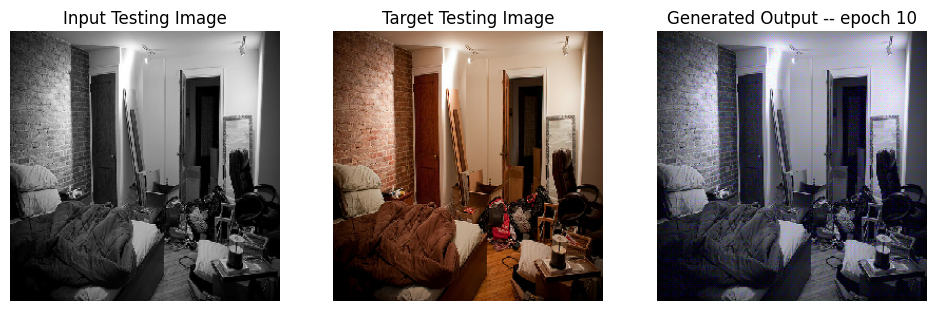

SSIM Score: 0.5739203095436096
PSNR Score: 17.535022735595703
LPIPS Score: 1.3907067775726318
Epoch 10
Training Details
Generator-- total_loss:207.41 gan_loss:200.84 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 11 is 2075.937335729599 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:5.41 gan_loss:0.00 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:193.14 real_loss:143.83 generated_loss:49.31 --- SSIM 0.62 PSNR 18.93 LPIPS 1.64
Time taken for epoch 11 is 2134.2181787490845 sec
Number of iteration 313
Epoch 11
Training Details
Generator-- total_loss:204.94 gan_loss:198.37 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 12 is 2093.6117811203003 sec
Number of iteration 7393
Testing Details
Generator-

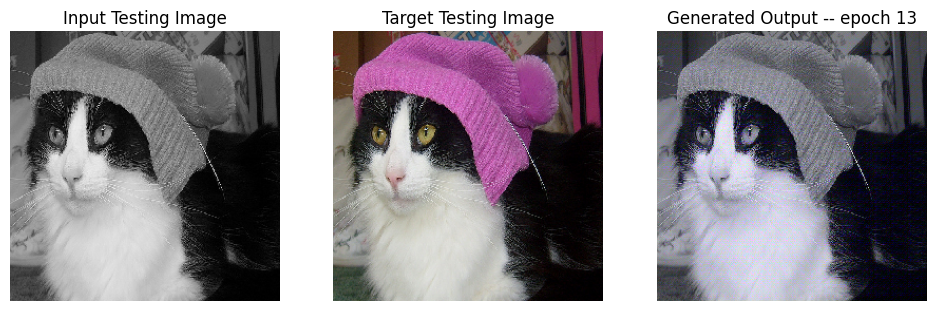

SSIM Score: 0.5549606084823608
PSNR Score: 19.260398864746094
LPIPS Score: 1.336869239807129
Epoch 13
Training Details
Generator-- total_loss:268.65 gan_loss:262.08 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 14 is 2085.413135290146 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:5.49 gan_loss:0.09 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:215.32 real_loss:204.46 generated_loss:10.86 --- SSIM 0.62 PSNR 18.95 LPIPS 1.63
Time taken for epoch 14 is 2143.889146089554 sec
Number of iteration 313
Epoch 14
Training Details
Generator-- total_loss:280.35 gan_loss:273.78 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 15 is 2122.1323657035828 sec
Number of iteration 7393
Testing Details
Generator-- 

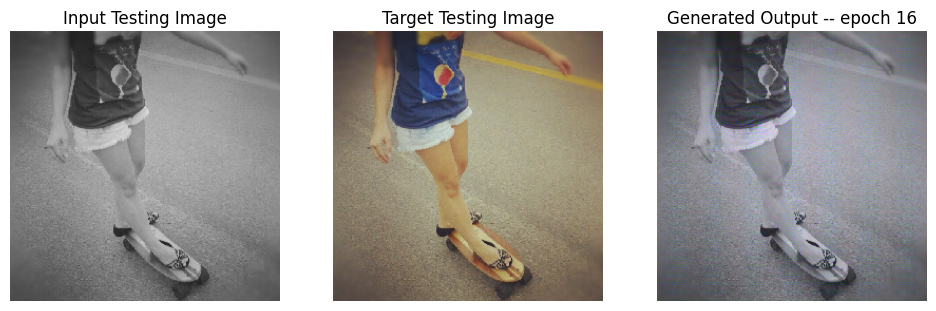

SSIM Score: 0.6323726773262024
PSNR Score: 20.38031578063965
LPIPS Score: 0.7742877006530762
Epoch 16
Training Details
Generator-- total_loss:531.56 gan_loss:524.99 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 17 is 2096.4647080898285 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:33.00 gan_loss:27.60 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:89.86 real_loss:75.86 generated_loss:14.00 --- SSIM 0.62 PSNR 18.94 LPIPS 1.64
Time taken for epoch 17 is 2155.216886281967 sec
Number of iteration 313
Epoch 17
Training Details
Generator-- total_loss:306.14 gan_loss:299.57 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.07 real_loss:0.00 generated_loss:0.06 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 18 is 2098.232302904129 sec
Number of iteration 7393
Testing Details
Generator-- 

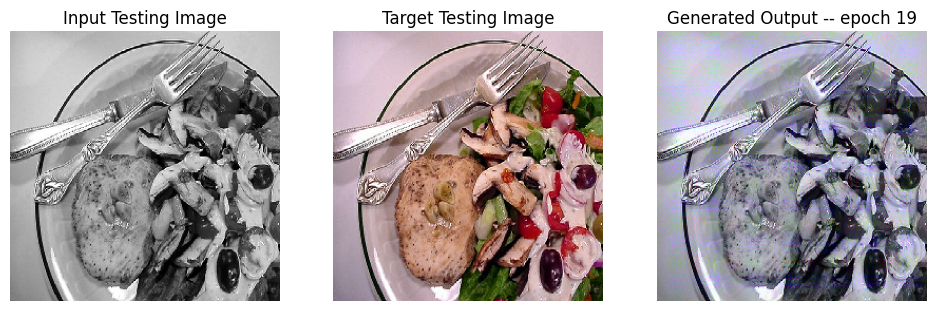

SSIM Score: 0.6816108822822571
PSNR Score: 18.074865341186523
LPIPS Score: 1.8697682619094849
Epoch 19
Training Details
Generator-- total_loss:596.25 gan_loss:589.68 l1_loss:0.08 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:0.07 real_loss:0.07 generated_loss:0.00 --- SSIM 0.47 PSNR 16.79 LPIPS 2.39
Time taken for epoch 20 is 2155.1929755210876 sec
Number of iteration 7393
Testing Details
Generator-- total_loss:84.37 gan_loss:78.98 l1_loss:0.07 l2_loss:0.00 perceptual_loss:0.00 Discriminator-- total_loss:103.58 real_loss:103.32 generated_loss:0.26 --- SSIM 0.62 PSNR 18.95 LPIPS 1.63
Time taken for epoch 20 is 2213.9444942474365 sec
Number of iteration 313


In [47]:
fit(train_dataset, epochs, test_dataset, gen)

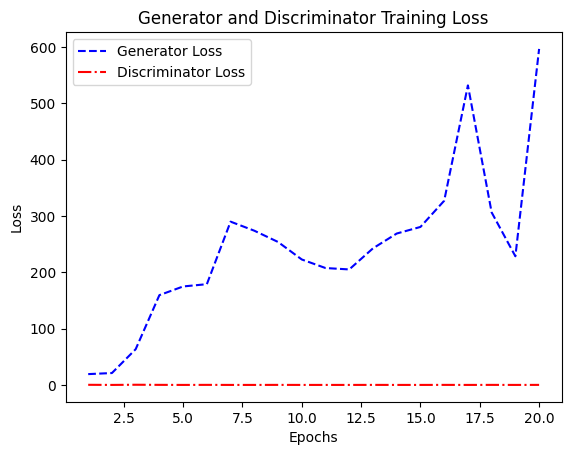

In [48]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

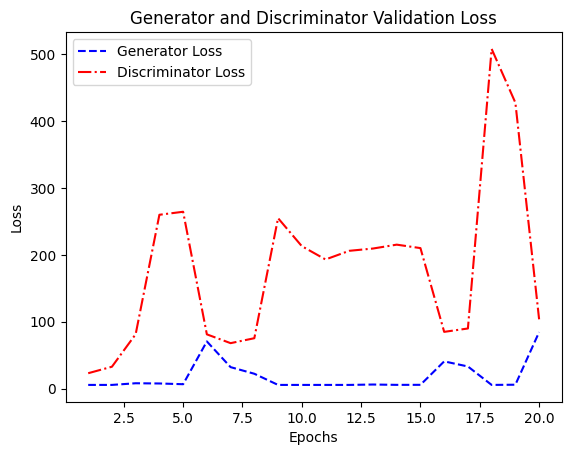

In [49]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

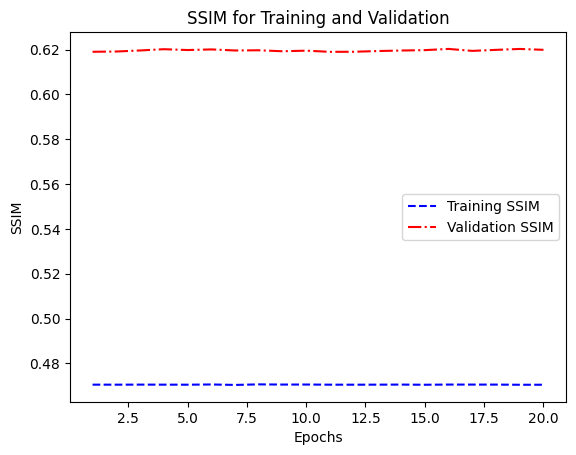

In [50]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_ssim, '--b', label='Training SSIM')
plt.plot(epochs, testing_ssim, '-.r', label='Validation SSIM')
plt.title('SSIM for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('/kaggle/working/SSIM_plot_1.png')
plt.show()

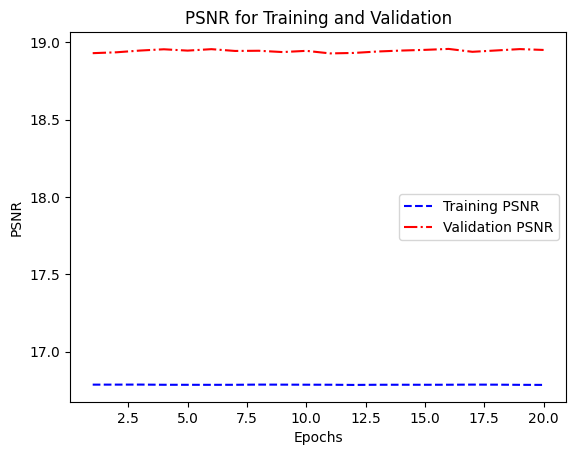

In [51]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_psnr, '--b', label='Training PSNR')
plt.plot(epochs, testing_psnr, '-.r', label='Validation PSNR')
plt.title('PSNR for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('/kaggle/working/PSNR_plot_1.png')
plt.show()

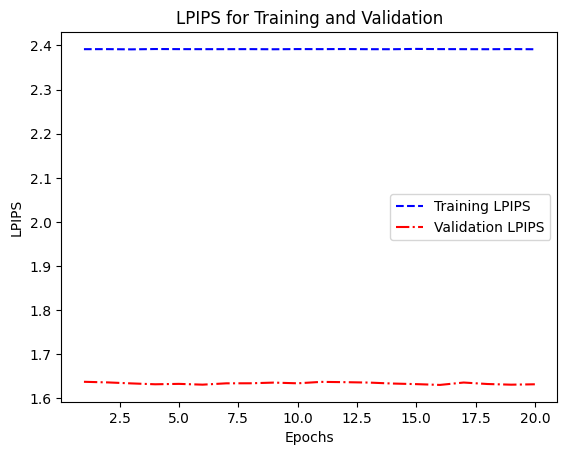

In [52]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_lpips, '--b', label='Training LPIPS')
plt.plot(epochs, testing_lpips, '-.r', label='Validation LPIPS')
plt.title('LPIPS for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('LPIPS')
plt.legend()
plt.savefig('/kaggle/working/LPIPS_plot_1.png')
plt.show()

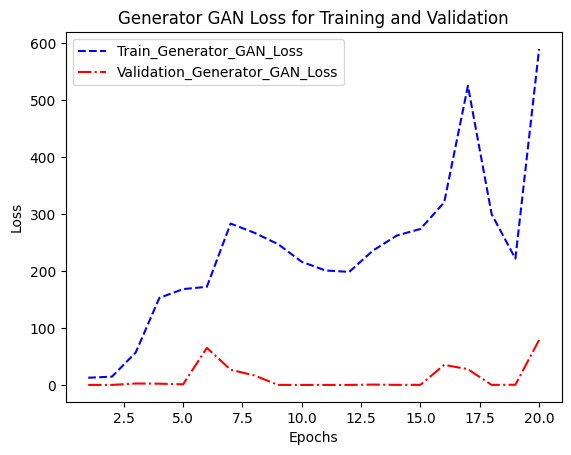

In [53]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses, '-.r', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

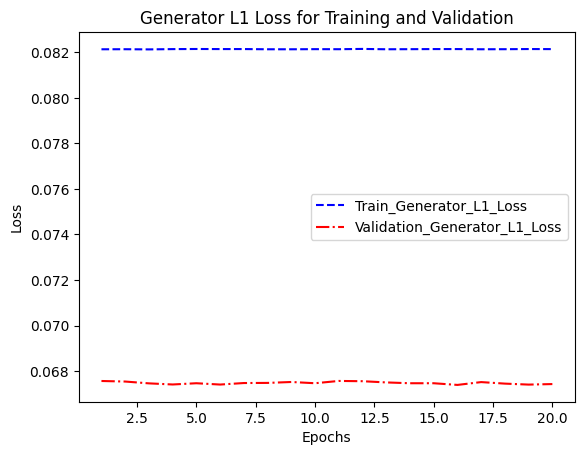

In [54]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-.r', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

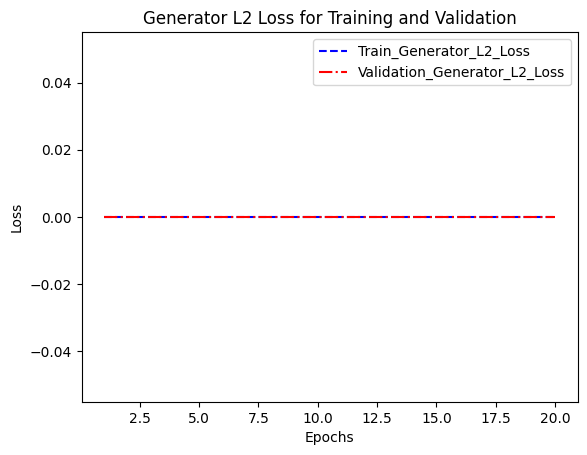

In [55]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l2_losses, '--b', label='Train_Generator_L2_Loss')
plt.plot(epochs, test_generator_l2_losses, '-.r', label='Validation_Generator_L2_Loss')
plt.title('Generator L2 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L2_plot_1.png')
plt.show()

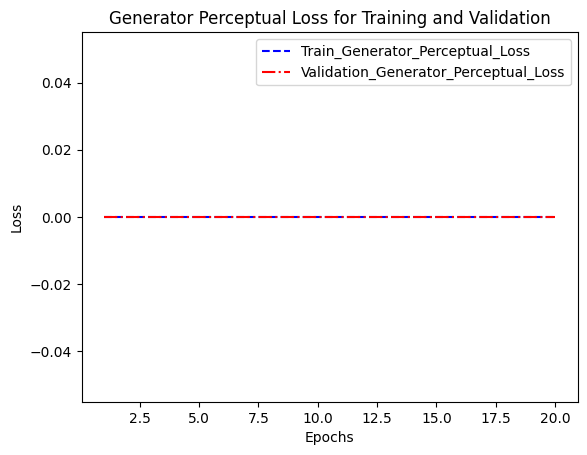

In [56]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_perceptual_losses, '--b', label='Train_Generator_Perceptual_Loss')
plt.plot(epochs, test_generator_perceptual_losses, '-.r', label='Validation_Generator_Perceptual_Loss')
plt.title('Generator Perceptual Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_Perceptual_plot_1.png')
plt.show()

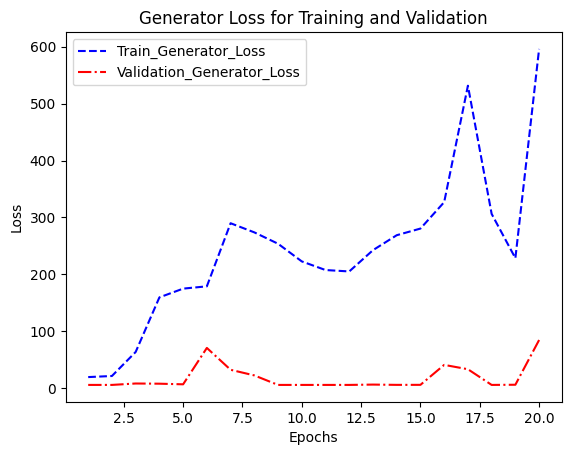

In [57]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-.r', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

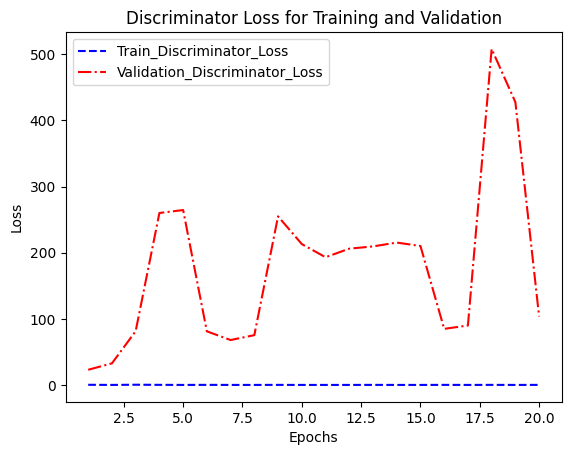

In [58]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

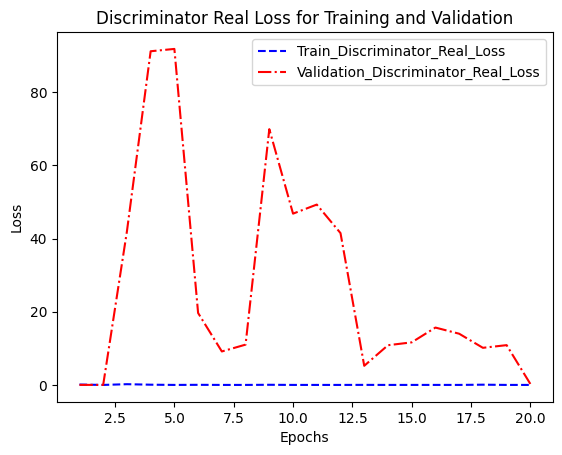

In [59]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-.r', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

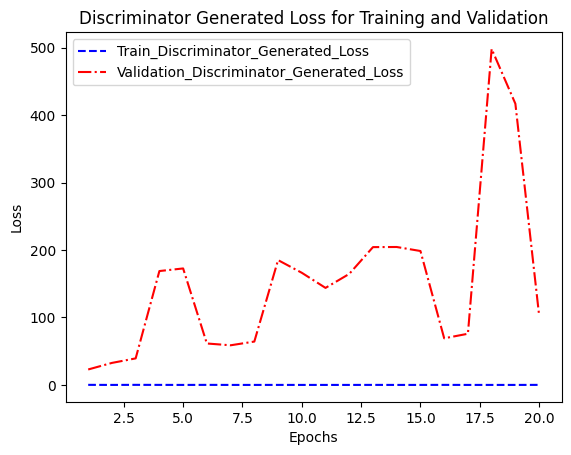

In [60]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses, '-.r', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [61]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [62]:
os.mkdir('/kaggle/working/modelsJan20')

In [63]:
gen.save('/kaggle/working/modelsJan20/gen.h5')
gen.save_weights('/kaggle/working/modelsJan20/gen.keras')
disc.save('/kaggle/working/modelsJan20/disc.h5')
disc.save_weights('/kaggle/working/modelsJan20/disc.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [65]:
import subprocess
from IPython.display import FileLink, display

In [66]:
download_file('/kaggle/working', 'outputJan20')

/kaggle/working/outputJan20.zip